In [1]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import pickle
from tqdm import tqdm
import gait
from train import CVAE_FULL

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/tensorflow/python/f

In [5]:
image_vec_shape = 12
gait_key_poses = 16
conditional_vec_shape = 4
pose_image_shape = (160,160,1)
batch_size = 50
full_vec_shape = image_vec_shape+conditional_vec_shape
n_timesteps = 3
angle = '090'

In [7]:
encoder = keras.models.Model(CVAE_FULL.input, CVAE_FULL.get_layer('concat_zcond').output)
encoded_vec = gait.encode_data(encoder,label_angle='090')

100%|██████████| 124/124 [00:06<00:00, 18.42it/s]


In [33]:
class GANDataGenerator(keras.utils.Sequence):
    def __init__(self, generator, encoded_vec, preprocess=None,  batch_size = 50, full_vec_shape=(1,16), dim=(160,160), n_classes=16, shuffle=True):
        self.dim = dim
        self.encoded_vec = encoded_vec
        self.full_vec = full_vec_shape
        self.batch_size = batch_size//2
        self.gen = generator
        self.preprocess = preprocess or (lambda x : x)
        self.n_channels = 1
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data = self.correlate()
        self.on_epoch_end()
        
    def correlate(self):
        data = []
        for folder in self.encoded_vec:
            i = 0
            for filename in sorted(os.listdir(folder)):
                if file[:-3]!='pkl' and file[:-3]!='npy' and file[:-3]!='npz':
                    data.append(['/'.join([folder, filename]), self.encoded_vec[folder][i:i+1,:]])
                    i += 1
        return data
        
    def __len__(self):
        return int(np.floor(len(self.data)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        files_temp = [self.data[k] for k in indexes]
        
        X,y = self.__data_generation(files_temp)
        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, files_temp):
        X = np.empty((2*self.batch_size, *self.dim, self.n_channels))
        y = np.append(np.ones((self.batch_size,1)),np.zeros((self.batch_size,1))).reshape(2*self.batch_size)
        for i,[filename,enc]  in enumerate(files_temp):
            X[i,] = cv2.copyMakeBorder(self.preprocess(cv2.imread(filename)), 0, 0, 20, 20, cv2.BORDER_CONSTANT, (0,0,0)).reshape(*self.dim, self.n_channels)/255.
        for i in range(self.batch_size, 2*self.batch_size):    
            X[i,] = self.gen(self.data[enc])
        return X, y

In [31]:
def define_discriminator():
    in_vec = keras.layers.Input(shape=(full_vec_shape,))
    vec_x = keras.layers.Dense(32, activation='relu')(in_vec)
    vec_x = keras.layers.Dense(64, activation='relu')(vec_x)
    in_img = keras.layers.Input(shape=pose_image_shape)
    x = keras.layers.Conv2D()
    
    model = keras.models.Model([in_src_image, in_target_image], ver)
    model.compile(loss='binary_crossentropy',optimizer='Adam')
    return model

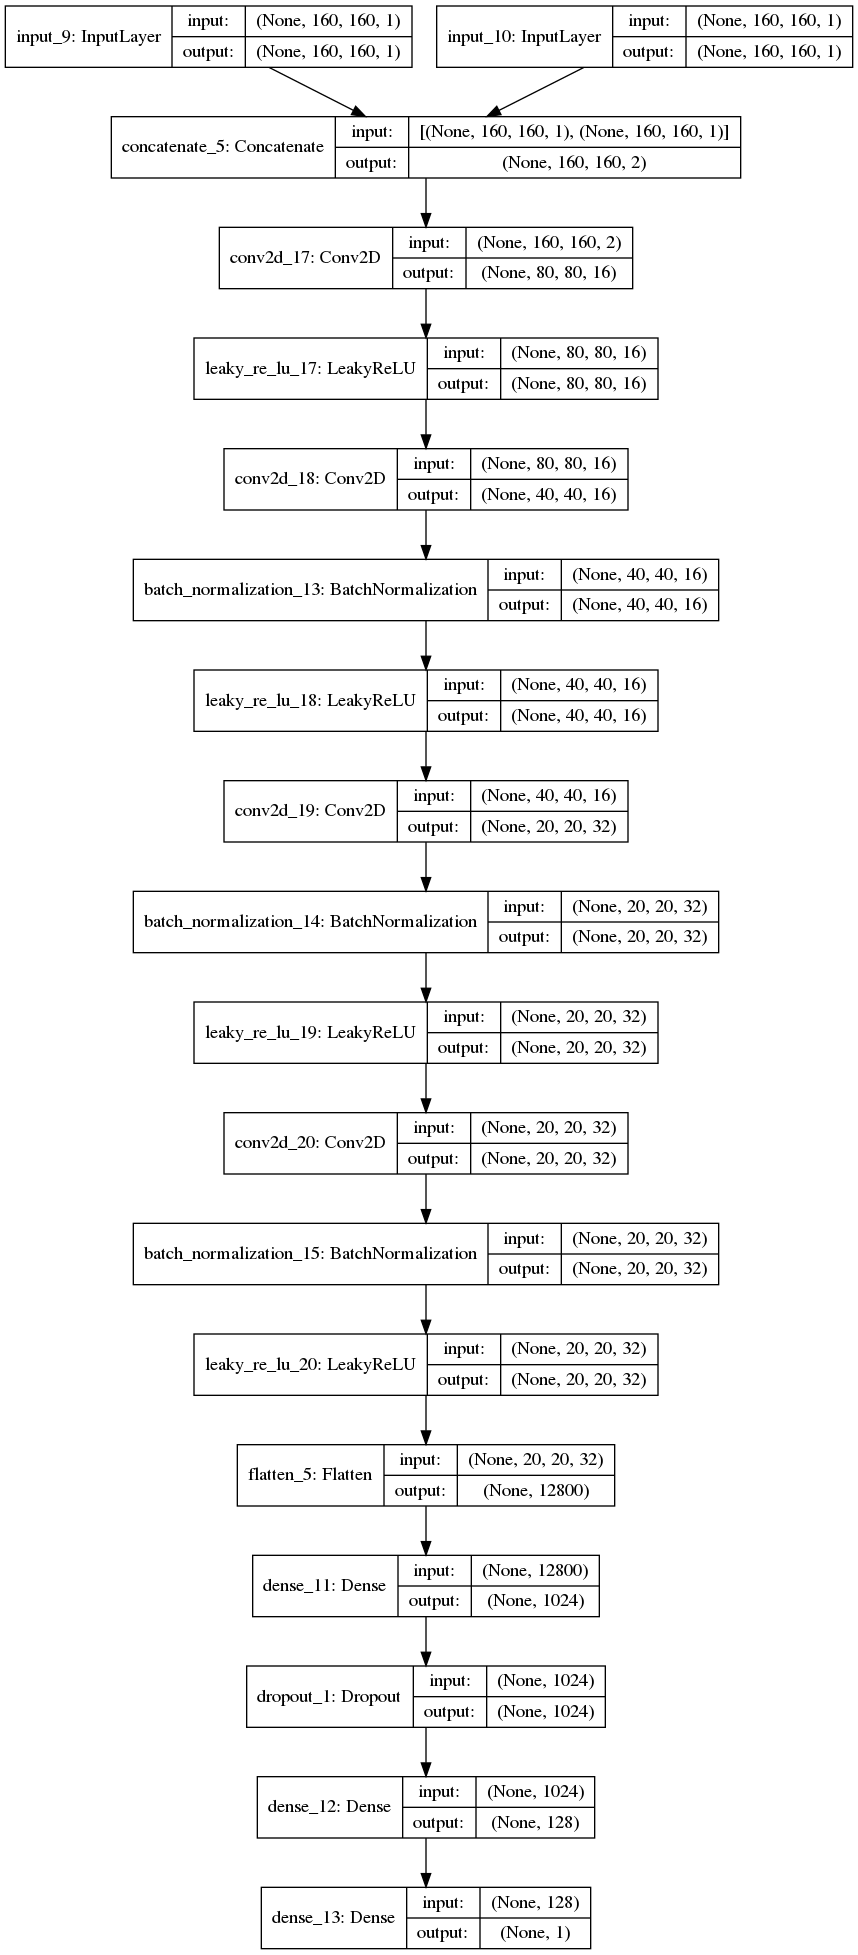

In [32]:
m = define_discriminator()
plot_model(m, to_file='/tmp/a.png', show_shapes=True, show_layer_names=True)
im = Image.open('/tmp/a.png')
im